In [1]:
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import tensorflow as tf

2022-05-19 01:12:11.325222: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [3]:
import os
import sys
BASE_DIR = '/home/keondopark/votenet_tf'
ROOT_DIR = BASE_DIR
sys.path.append(os.path.join(ROOT_DIR, 'utils'))
sys.path.append(os.path.join(ROOT_DIR, 'models'))
sys.path.append(os.path.join(ROOT_DIR, 'sunrgbd'))

In [4]:
os.environ['CUDA_VISIBLE_DEVICES']="3"

In [5]:
from utils.pc_util import random_sampling, read_ply

import votenet_tf
from pointnet2 import tf_utils

import tensorflow as tf
from tensorflow.keras import layers

from sunrgbd.sunrgbd_detection_dataset_tf import SunrgbdDetectionVotesDataset_tfrecord, MAX_NUM_OBJ
from sunrgbd.model_util_sunrgbd import SunrgbdDatasetConfig
import voting_module_tf
import json
import tqdm

In [9]:
DATASET_CONFIG = SunrgbdDatasetConfig()

In [13]:
model_config = json.load(open('configs/config_2way_nofp_sep_4.json'))

# Build the model

In [14]:
# Init the model and optimzier    
net = votenet_tf.VoteNet(num_proposal=256, input_feature_dim=3+ DATASET_CONFIG.num_class, vote_factor=1,
    #sampling='seed_fps', num_class=DC.num_class,
    sampling='vote_fps', num_class=DATASET_CONFIG.num_class,
    num_heading_bin=DATASET_CONFIG.num_heading_bin,
    num_size_cluster=DATASET_CONFIG.num_size_cluster,
    mean_size_arr=DATASET_CONFIG.mean_size_arr,
    model_config=model_config)
print('Constructed model.')

Constructed model.


# Get checkpoint and resotre weights

In [15]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
checkpoint_path = os.path.join(BASE_DIR, 'tf_ckpt', model_config['model_id'])
ckpt = tf.train.Checkpoint(epoch=tf.Variable(1), optimizer=optimizer, net=net)
manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=3)
ckpt.restore(manager.latest_checkpoint)

In [19]:
BATCH_SIZE=8
# Load and preprocess input point cloud     
pc = tf.convert_to_tensor(np.random.random([BATCH_SIZE,20000,3+1+1+10+1]))

# Model inference
inputs = {'point_clouds': tf.convert_to_tensor(pc)}

end_points = net(inputs['point_clouds'], training=False)

# Define voting and proposal modules

In [24]:
class nnInVotingModule(tf.keras.Model):
    def __init__(self, vote_factor, seed_feature_dim):            
        super().__init__()

        self.vote_factor = vote_factor
        self.in_dim = seed_feature_dim            
        self.out_dim = self.in_dim # due to residual feature, in_dim has to be == out_dim
        self.sep_coords = sep_coords
        self.conv0 = layers.Conv2D(filters=self.in_dim, kernel_size=1)
        self.conv1 = layers.Conv2D(filters=self.in_dim, kernel_size=1)        
        self.conv2 = layers.Conv2D(filters=self.in_dim, kernel_size=1)
        self.conv3 = layers.Conv2D(filters=(self.out_dim+3) * self.vote_factor, kernel_size=1)         
        self.bn0 = layers.BatchNormalization(axis=-1)
        self.bn1 = layers.BatchNormalization(axis=-1)
        self.bn2 = layers.BatchNormalization(axis=-1)
        self.relu0 = layers.ReLU(6)
        self.relu1 = layers.ReLU(6)
        self.relu2 = layers.ReLU(6)

    def call(self, seed_xyz, seed_features):

        num_seed = 1024           

        net0 = self.relu0(self.bn0(self.conv0(seed_features)))
        net = self.relu1(self.bn1(self.conv1(net0))) 
        net = self.relu2(self.bn2(self.conv2(net))) 
        net = self.conv3(net)
        return net

class vaModule(tf.keras.Model):
    def __init__(self, mlp_spec, input_shape, nsample=0):
        super().__init__()
        self.sharedMLP = tf_utils.SharedMLP(mlp_spec, bn=True, input_shape=input_shape)
        self.npoint = 256
        self.nsample = nsample            
        self.sep_coords = sep_coords
        self.max_pool = layers.MaxPooling2D(pool_size=(1, 16), strides=(1,16), data_format="channels_last")            

        NH = DATASET_CONFIG.num_heading_bin
        NC = DATASET_CONFIG.num_size_cluster
        num_class = DATASET_CONFIG.num_class
        
        self.conv1 = layers.Conv2D(filters=128, kernel_size=1)        
        self.conv2 = layers.Conv2D(filters=128, kernel_size=1)
        self.conv3 = layers.Conv2D(filters=2+3+NH*2+NC*4+num_class, kernel_size=1)
        self.bn1 = layers.BatchNormalization(axis=-1)
        self.bn2 = layers.BatchNormalization(axis=-1)
        self.relu1 = layers.ReLU(6)
        self.relu2 = layers.ReLU(6)

    def call(self, xyz, grouped_features):            

        new_features = self.max_pool(self.sharedMLP(grouped_features))     
        # --------- PROPOSAL GENERATION ---------
        net = self.relu1(self.bn1(self.conv1(new_features)))
        net = self.relu2(self.bn2(self.conv2(net))) 
        net = self.conv3(net)
        return net

## Create pseudo modules to get activations easier

In [29]:
# Create pseudo module to have more control on activations
voting = nnInVotingModule(vote_factor=1, seed_feature_dim=256)        

# Build network by forwarding once
dummy_in_voting_features = tf.convert_to_tensor(np.random.random([BATCH_SIZE,1024,1,256*3])) # (B, num_seed, 1, 256*3)
dummy_in_voting_xyz =  tf.convert_to_tensor(np.random.random([BATCH_SIZE,1024,1,3])) # (B, num_seed, 1, 3)        
dummy_out = voting(dummy_in_voting_xyz, dummy_in_voting_features)

# Set weights of the pseudo module
layer = voting
layer.conv0.set_weights(net.vgen.conv0.get_weights())
layer.conv1.set_weights(net.vgen.conv1.get_weights())
layer.conv2.set_weights(net.vgen.conv2.get_weights())
layer.conv3.set_weights(net.vgen.conv3.get_weights())

layer.bn0.set_weights(net.vgen.bn0.get_weights())
layer.bn1.set_weights(net.vgen.bn1.get_weights())
layer.bn2.set_weights(net.vgen.bn2.get_weights())

In [30]:
# Create pseudo module to have more control on activations
va_mlp = vaModule(mlp_spec=[128, 128, 128, 128], nsample=16, input_shape=[256,16,256+3])

# Build network by forwarding once
dummy_va_features = tf.convert_to_tensor(np.random.random([BATCH_SIZE,256,16,(256+3)]), dtype=tf.float32) # (B, npoint, 3 + nsample*(C+3)) 
dummy_va_xyz = tf.convert_to_tensor(np.random.random([BATCH_SIZE,256,3]), dtype=tf.float32) # (B, npoint, 3 + nsample*(C+3)) 
dummy_out = va_mlp(dummy_va_xyz, dummy_va_features)

# Set weights of the pseudo module
layer = va_mlp.sharedMLP
layer.set_weights(net.pnet.mlp_module.get_weights())

layer = va_mlp
layer.conv1.set_weights(net.pnet.conv1.get_weights())
layer.conv2.set_weights(net.pnet.conv2.get_weights())
layer.conv3.set_weights(net.pnet.conv3.get_weights())

layer.bn1.set_weights(net.pnet.bn1.get_weights())
layer.bn2.set_weights(net.pnet.bn2.get_weights())

## Get activations distribution

In [28]:
TRAIN_DATASET = SunrgbdDetectionVotesDataset_tfrecord('train', num_points=20000,
        augment=False, shuffle=True, batch_size=BATCH_SIZE,
        use_color=False, use_height=True,
        use_painted=True, DC=DATASET_CONFIG)

ds = TRAIN_DATASET.preprocess()
ds = ds.prefetch(BATCH_SIZE)

/data/sunrgbd_pc_train_painted_tf4
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


In [64]:
first = True
cnt = 0
for batch_data in ds:    
    cnt += 1
    print('Processing ', cnt, '-th batch')
    inputs = batch_data[0]
    end_points = net(inputs, training=False)
    
    seed_xyz = tf.expand_dims(end_points['seed_xyz'], axis=-2)
    seed_features = tf.expand_dims(end_points['seed_features'], axis=-2)
    va_xyz = end_points['aggregated_vote_xyz']
    va_grouped_features = end_points['va_grouped_features']
    
    voting_out = voting(seed_xyz, seed_features)  
    proposal_out = va_mlp(va_xyz, va_grouped_features)
    
    if first:
        voting_act_all = voting_out        
        proposal_act_all = proposal_out        
        first = False
    else:
        voting_act_all = tf.concat([voting_act_all, voting_out], axis=0)        
        proposal_act_all = tf.concat([proposal_act_all, proposal_out], axis=0)        

Processing  1 -th batch
Processing  2 -th batch
Processing  3 -th batch
Processing  4 -th batch
Processing  5 -th batch
Processing  6 -th batch
Processing  7 -th batch
Processing  8 -th batch
Processing  9 -th batch
Processing  10 -th batch
Processing  11 -th batch
Processing  12 -th batch
Processing  13 -th batch
Processing  14 -th batch
Processing  15 -th batch
Processing  16 -th batch
Processing  17 -th batch
Processing  18 -th batch
Processing  19 -th batch
Processing  20 -th batch
Processing  21 -th batch
Processing  22 -th batch
Processing  23 -th batch
Processing  24 -th batch
Processing  25 -th batch
Processing  26 -th batch
Processing  27 -th batch
Processing  28 -th batch
Processing  29 -th batch
Processing  30 -th batch
Processing  31 -th batch
Processing  32 -th batch
Processing  33 -th batch
Processing  34 -th batch
Processing  35 -th batch
Processing  36 -th batch
Processing  37 -th batch
Processing  38 -th batch
Processing  39 -th batch
Processing  40 -th batch
Processin

Processing  321 -th batch
Processing  322 -th batch
Processing  323 -th batch
Processing  324 -th batch
Processing  325 -th batch
Processing  326 -th batch
Processing  327 -th batch
Processing  328 -th batch
Processing  329 -th batch
Processing  330 -th batch
Processing  331 -th batch
Processing  332 -th batch
Processing  333 -th batch
Processing  334 -th batch
Processing  335 -th batch
Processing  336 -th batch
Processing  337 -th batch
Processing  338 -th batch
Processing  339 -th batch
Processing  340 -th batch
Processing  341 -th batch
Processing  342 -th batch
Processing  343 -th batch
Processing  344 -th batch
Processing  345 -th batch
Processing  346 -th batch
Processing  347 -th batch
Processing  348 -th batch
Processing  349 -th batch
Processing  350 -th batch
Processing  351 -th batch
Processing  352 -th batch
Processing  353 -th batch
Processing  354 -th batch
Processing  355 -th batch
Processing  356 -th batch
Processing  357 -th batch
Processing  358 -th batch
Processing  

Processing  637 -th batch
Processing  638 -th batch
Processing  639 -th batch
Processing  640 -th batch
Processing  641 -th batch
Processing  642 -th batch
Processing  643 -th batch
Processing  644 -th batch
Processing  645 -th batch
Processing  646 -th batch
Processing  647 -th batch
Processing  648 -th batch
Processing  649 -th batch
Processing  650 -th batch
Processing  651 -th batch
Processing  652 -th batch
Processing  653 -th batch
Processing  654 -th batch
Processing  655 -th batch
Processing  656 -th batch
Processing  657 -th batch
Processing  658 -th batch
Processing  659 -th batch
Processing  660 -th batch
Processing  661 -th batch


In [65]:
voting_act_all = voting_act_all.numpy()
proposal_act_all = proposal_act_all.numpy()

2022-05-08 20:42:54.004913: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 5606666240 exceeds 10% of free system memory.
2022-05-08 20:44:06.879102: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 427535360 exceeds 10% of free system memory.


In [66]:
voting_act_coords = voting_act_all[:,:,:,:3]
voting_act_features = voting_act_all[:,:,:,3:]
proposal_act_coords = proposal_act_all[:,:,:,:3]
proposal_act_features = proposal_act_all[:,:,:,3:]

## Get convolution weights

In [57]:
voting_w, voting_b = net.vgen.conv3.get_weights()
proposal_w, proposal_b = net.pnet.conv3.get_weights()

In [47]:
voting_w_coords = voting_w[:,:,:,:3]
voting_w_features = voting_w[:,:,:,3:]
proposal_w_coords = proposal_w[:,:,:,:3]
proposal_w_features = proposal_w[:,:,:,3:]

## Save weights and activations

In [55]:
SAVE_DIR = '/data/votenet_WandA_dist'

In [61]:
os.makedirs(SAVE_DIR, exist_ok=True)
np.save(os.path.join(SAVE_DIR, 'voting_w'), voting_w)
np.save(os.path.join(SAVE_DIR, 'proposal_w'), proposal_w)

In [67]:
np.save(os.path.join(SAVE_DIR, 'voting_act_all'), voting_act_all)
np.save(os.path.join(SAVE_DIR, 'proposal_act_all'), proposal_act_all)

## Load weights and activations

In [1]:
import numpy as np
import os, sys
import tensorflow as tf
import math
import matplotlib.pyplot as plt
import seaborn as sns

2022-05-17 13:27:36.469850: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
LOAD_DIR = '/data/votenet_WandA_dist'

In [3]:
voting_w = np.load(os.path.join(LOAD_DIR, 'voting_w.npy'))
proposal_w = np.load(os.path.join(LOAD_DIR, 'proposal_w.npy'))
voting_act_all = np.load(os.path.join(LOAD_DIR, 'voting_act_all.npy'))
proposal_act_all = np.load(os.path.join(LOAD_DIR, 'proposal_act_all.npy'))

## Calculate KL divergence between channels


In [140]:
def calculate_kl_between_chn(entire_layer):
    # Get layer information
    num_chn = entire_layer.shape[-1]
    max_chn = np.max(entire_layer)
    min_chn = np.min(entire_layer)
    bins_start = math.floor(min_chn)
    bins_end = math.ceil(max_chn)
    bins_layer = np.linspace(bins_start, bins_end, (bins_end - bins_start) * 10 + 1) #0.1 interval
    
    kl = tf.keras.losses.KLDivergence()
    kl_chn = np.zeros((num_chn, num_chn))
    data_cnt = entire_layer.shape[0] * entire_layer.shape[1] * entire_layer.shape[2]
    
    for i in range(num_chn):
        print(f"Processing {i}-th channel")
        for j in range(i+1, num_chn):            
            a = np.histogram(entire_layer[:,:,:,i], bins=bins_layer)[0] / data_cnt
            b = np.histogram(entire_layer[:,:,:,j], bins=bins_layer)[0] / data_cnt
            kl_chn[i,j] = kl(a, b)
            kl_chn[j,i] = kl(b, a)
    return kl_chn

In [128]:
kl_voting_w = calculate_kl_between_chn(voting_w)

In [144]:
kl_proposal_w = calculate_kl_between_chn(proposal_w)

Processing 0-th channel
Processing 1-th channel
Processing 2-th channel
Processing 3-th channel
Processing 4-th channel
Processing 5-th channel
Processing 6-th channel
Processing 7-th channel
Processing 8-th channel
Processing 9-th channel
Processing 10-th channel
Processing 11-th channel
Processing 12-th channel
Processing 13-th channel
Processing 14-th channel
Processing 15-th channel
Processing 16-th channel
Processing 17-th channel
Processing 18-th channel
Processing 19-th channel
Processing 20-th channel
Processing 21-th channel
Processing 22-th channel
Processing 23-th channel
Processing 24-th channel
Processing 25-th channel
Processing 26-th channel
Processing 27-th channel
Processing 28-th channel
Processing 29-th channel
Processing 30-th channel
Processing 31-th channel
Processing 32-th channel
Processing 33-th channel
Processing 34-th channel
Processing 35-th channel
Processing 36-th channel
Processing 37-th channel
Processing 38-th channel
Processing 39-th channel
Processing

In [141]:
kl_voting_act = calculate_kl_between_chn(voting_act_all)

Processing 0-th channel
Processing 1-th channel
Processing 2-th channel
Processing 3-th channel
Processing 4-th channel
Processing 5-th channel
Processing 6-th channel
Processing 7-th channel
Processing 8-th channel
Processing 9-th channel
Processing 10-th channel
Processing 11-th channel
Processing 12-th channel
Processing 13-th channel
Processing 14-th channel
Processing 15-th channel
Processing 16-th channel
Processing 17-th channel
Processing 18-th channel
Processing 19-th channel
Processing 20-th channel
Processing 21-th channel
Processing 22-th channel
Processing 23-th channel
Processing 24-th channel
Processing 25-th channel
Processing 26-th channel
Processing 27-th channel
Processing 28-th channel
Processing 29-th channel
Processing 30-th channel
Processing 31-th channel
Processing 32-th channel
Processing 33-th channel
Processing 34-th channel
Processing 35-th channel
Processing 36-th channel
Processing 37-th channel
Processing 38-th channel
Processing 39-th channel
Processing

In [110]:
kl_proposal_act = calculate_kl_between_chn(proposal_act_all)

In [145]:
np.save(os.path.join(LOAD_DIR, 'kl_voting_w.npy'), kl_voting_w)
np.save(os.path.join(LOAD_DIR, 'kl_voting_act.npy'), kl_voting_act)
np.save(os.path.join(LOAD_DIR, 'kl_proposal_w.npy'), kl_proposal_w)
np.save(os.path.join(LOAD_DIR, 'kl_proposal_act.npy'), kl_proposal_act)

In [101]:
kl_voting_w = np.load(os.path.join(LOAD_DIR, 'kl_voting_w.npy'))
kl_voting_act = np.load(os.path.join(LOAD_DIR, 'kl_voting_act.npy'))
kl_proposal_w = np.load(os.path.join(LOAD_DIR, 'kl_proposal_w.npy'))
kl_proposal_act = np.load(os.path.join(LOAD_DIR, 'kl_proposal_act.npy'))

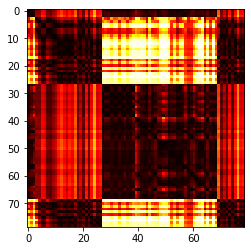

In [116]:
plt.imshow(kl_proposal_act, cmap='hot', interpolation='nearest')
plt.show()

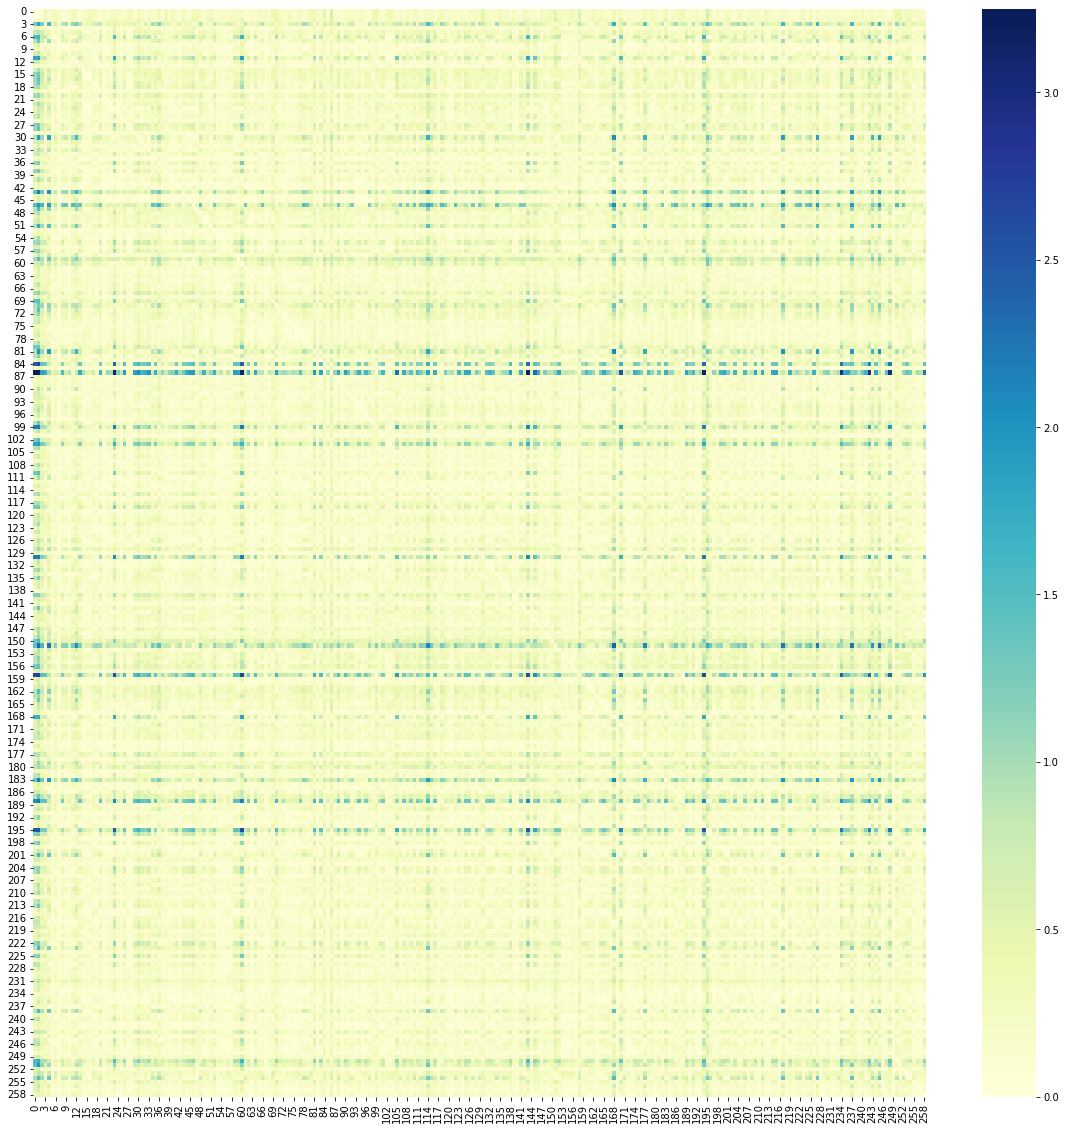

In [129]:
plt.figure(figsize=(20,20))
ax = sns.heatmap(kl_voting_w, cmap="YlGnBu")
plt.show()

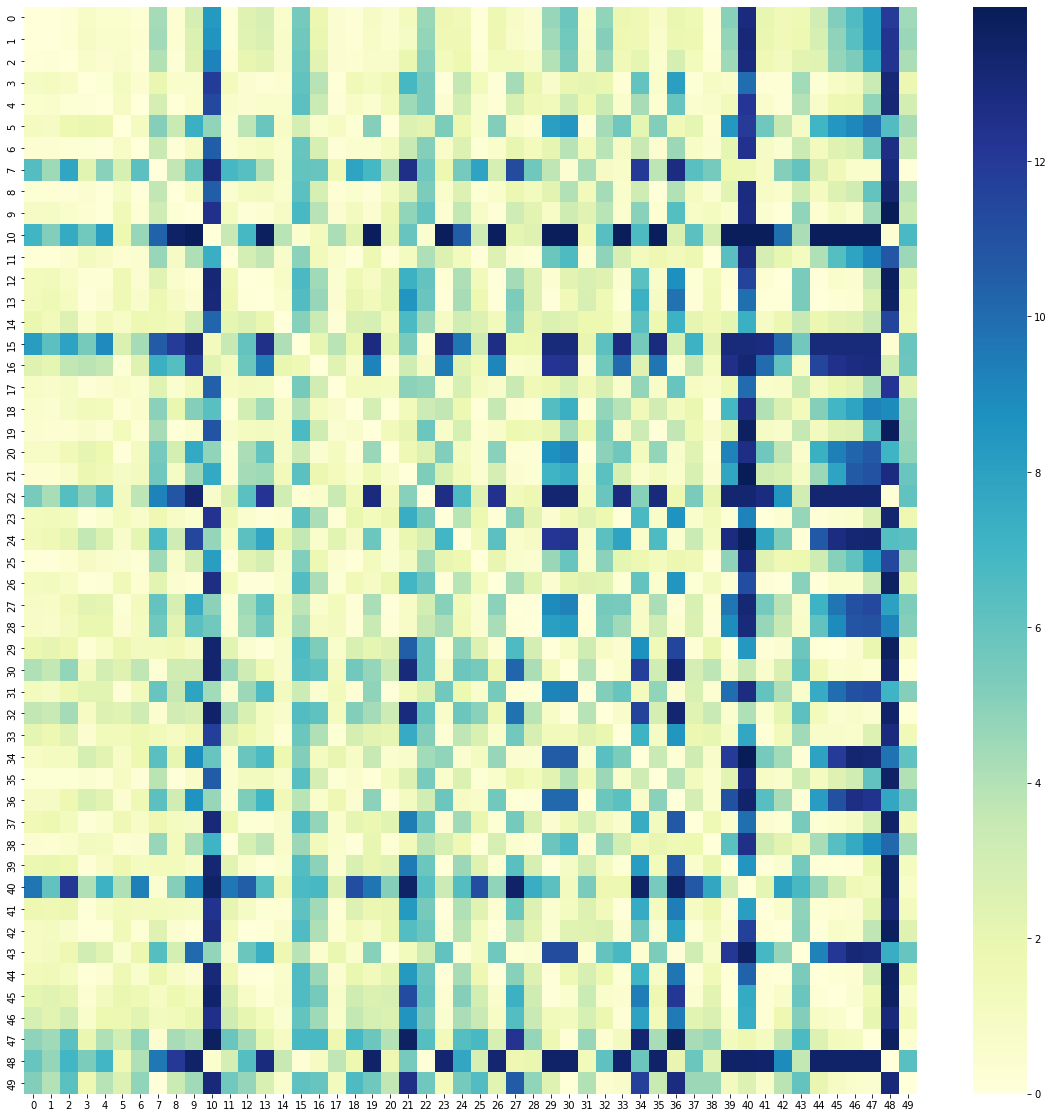

In [146]:
plt.figure(figsize=(20,20))
ax = sns.heatmap(kl_voting_act[:50,:50], cmap="YlGnBu")
plt.show()

<Figure size 1440x1440 with 0 Axes>

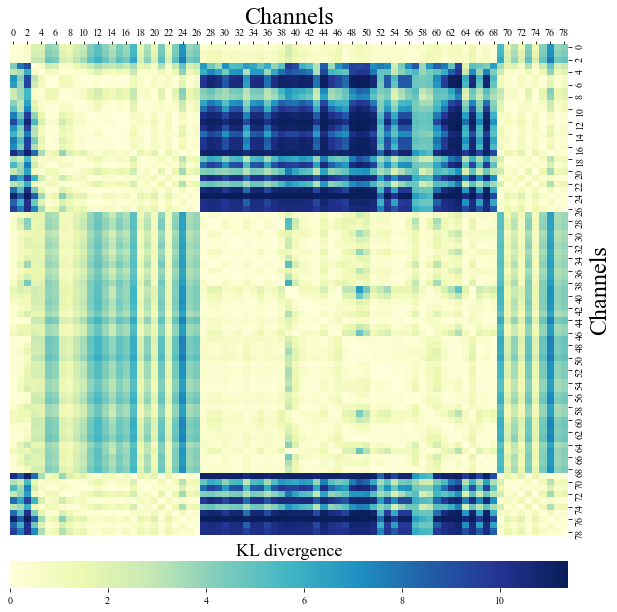

In [106]:
plt.figure(figsize=(20,20))
mask = np.zeros_like(kl_proposal_act)
#mask[np.tril_indices_from(mask)] = True

grid_kws = {"height_ratios": (.9, .05), "hspace": .1}
f, (ax, cbar_ax) = plt.subplots(2, gridspec_kw=grid_kws, figsize=(10,10))

#kl_proposal_act = kl_proposal_act.pivot("Channel", "Channel", "KL divergence")
# ax = sns.heatmap(flights, ax=ax,
#                  cbar_ax=cbar_ax,
#                  cbar_kws={"orientation": "horizontal"})

with sns.axes_style("white"):    
    #ax = sns.heatmap(corr, mask=mask, vmax=.3, square=True)
    ax = sns.heatmap(kl_proposal_act, ax=ax, cbar_ax=cbar_ax, mask=mask, cmap="YlGnBu", cbar_kws={"orientation": "horizontal"})
    ax.set_xlabel("Channels", fontsize=24, **{'fontname':'Times New Roman'})
    ax.xaxis.set_label_position('top') 
    ax.set_ylabel("Channels", fontsize=24, **{'fontname':'Times New Roman'})
    ax.yaxis.set_label_position('right') 
    ax.tick_params(right=True, top=True, labelright=True, labeltop=True, labelleft=False, left=False, labelbottom=False, bottom=False)
    #ax.set_title("KL divergence between channels in Proposal module", fontsize=18, **{'fontname':'Times New Roman'})
    cbar_ax.set_title("KL divergence", **{'fontname':'Times New Roman'}, fontsize=18)
plt.savefig("figs/KLdivergence.pdf", bbox_inches='tight', pad_inches=0.1)
plt.show()


In [44]:
np.max(proposal_act_all), np.min(proposal_act_all)

(20.512022, -144.43341)

In [56]:
np.linspace(-145, 21, (145+21) * 10+1)

array([-145. , -144.9, -144.8, ...,   20.8,   20.9,   21. ])

In [95]:
a = np.histogram(proposal_act_all[:,:,:,0], bins=np.linspace(-145, 21, (145+21) * 10+1))[0]
b = np.histogram(proposal_act_all[:,:,:,1], bins=np.linspace(-145, 21, (145+21) * 10+1))[0]
c = np.histogram(proposal_act_all[:,:,:,3], bins=np.linspace(-145, 21, (145+21) * 10+1))[0]

In [96]:
a = a / proposal_act_all.shape[0] / proposal_act_all.shape[1]
b = b / proposal_act_all.shape[0] / proposal_act_all.shape[1]
c = c / proposal_act_all.shape[0] / proposal_act_all.shape[1]

21

In [ ]:
bins=np.linspace(-145, 21, (145+21) * 10+1)



In [92]:
np.sum(a)

1.0

In [80]:
tf.convert_to_tensor(a, dtype=tf.int64)

<tf.Tensor: shape=(1660,), dtype=int64, numpy=array([0, 0, 0, ..., 0, 0, 0])>

In [81]:
tf.convert_to_tensor(b, dtype=tf.int64)

<tf.Tensor: shape=(1660,), dtype=int64, numpy=array([0, 0, 0, ..., 0, 0, 0])>

In [97]:
kl(a, b)

<tf.Tensor: shape=(), dtype=float64, numpy=0.2610524594783783>

In [98]:
kl(a, c)

<tf.Tensor: shape=(), dtype=float64, numpy=2.129596710205078>

In [46]:
np.max(proposal_act_all[:,:,:,0]), np.min(proposal_act_all[:,:,:,0])

(2.4414961, -3.8171964)

In [38]:
kl(proposal_act_all[:,:,:,1], proposal_act_all[:,:,:,3])

<tf.Tensor: shape=(), dtype=float32, numpy=-0.014054841>

# Draw distribution per channel

In [12]:
voting_act_features = voting_act_all[:,:,:,3:].reshape([voting_act_all.shape[0], voting_act_all.shape[1], voting_act_all.shape[2], int(voting_act_all.shape[3]/4), 4]) 

In [13]:
voting_act_features = np.sum(voting_act_features, axis=-1)

In [14]:
voting_act_features.shape

(5285, 1024, 1, 64)

In [15]:
num_channel = voting_act_features.shape[-1]
rows = (num_channel - 1) // 5 + 1
cols = 5

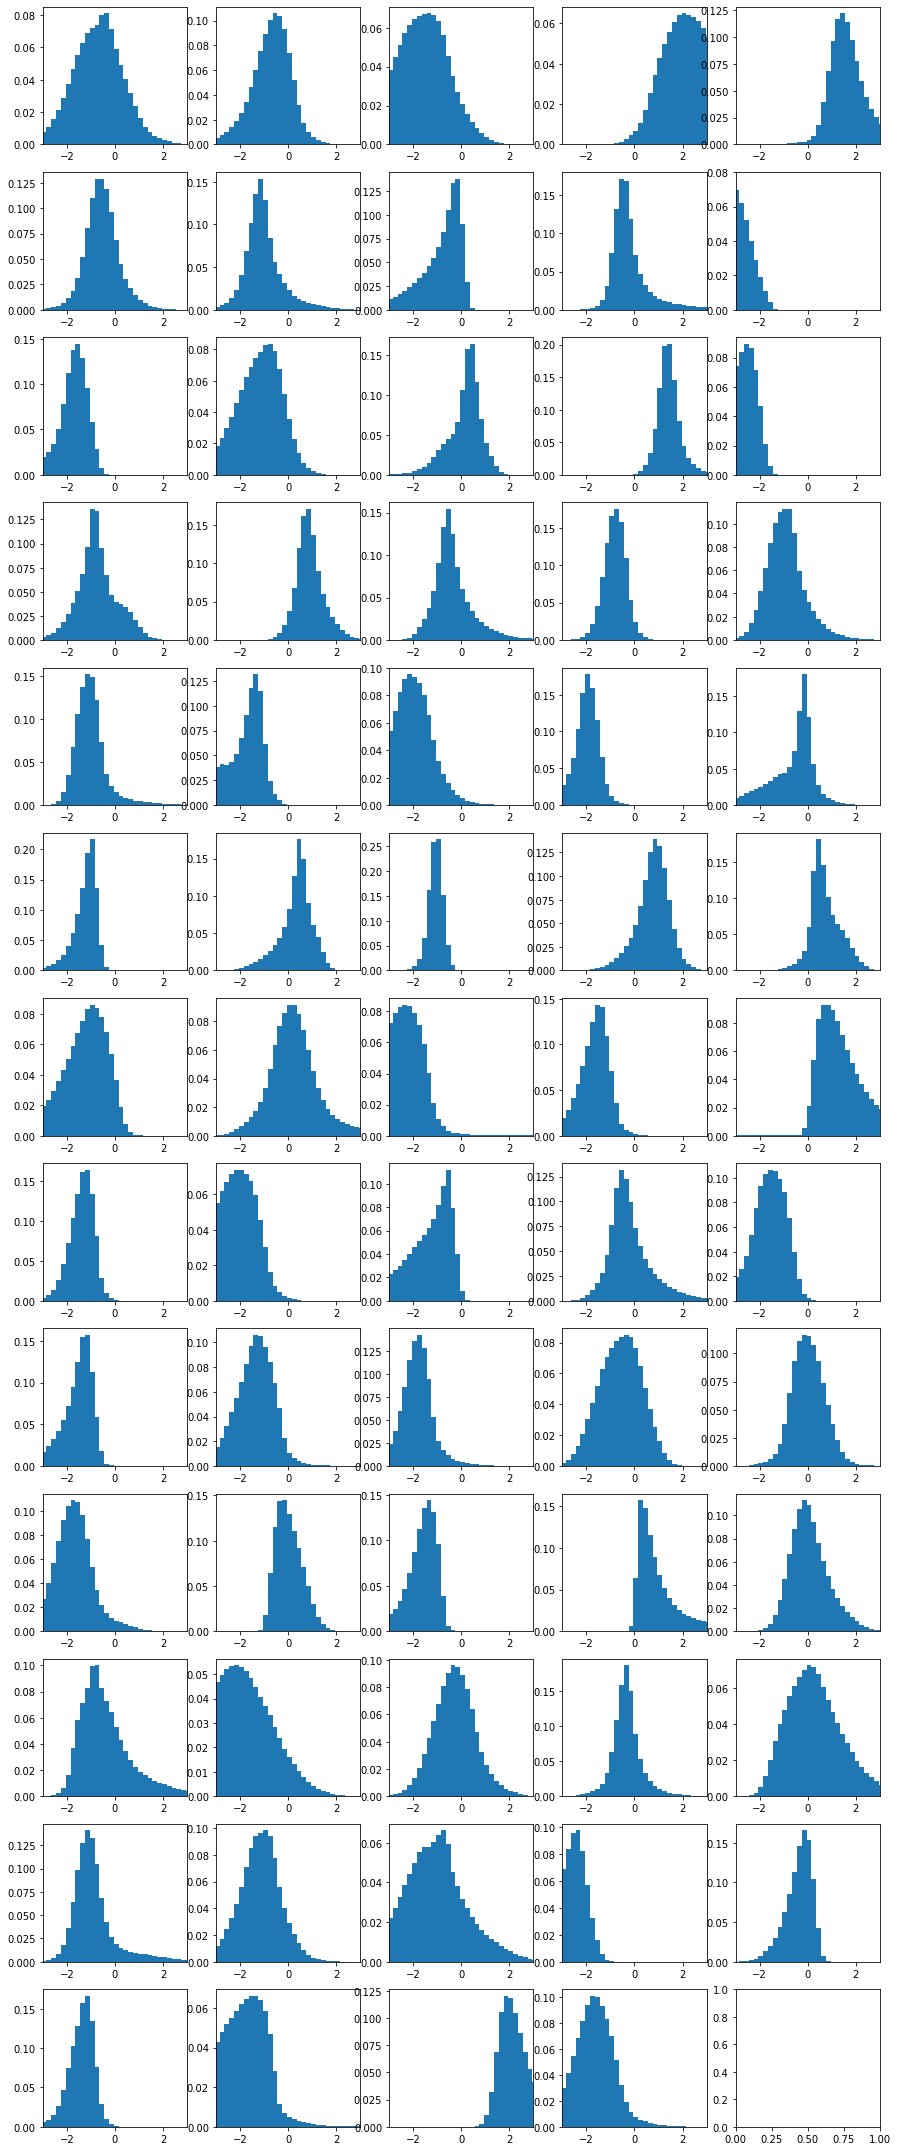

In [16]:
#Draw charts
data = np.reshape(voting_act_features, (-1))
bin_size = 0.2; min_edge = min(data); max_edge = max(data)
N = int((max_edge-min_edge)/bin_size); Nplus1 = N + 1
bin_list = np.linspace(min_edge, max_edge, Nplus1)

#plt.figure(figsize=(30,30))
fig, axs = plt.subplots(rows,  cols, figsize=(15,3*rows))
for i in range(rows):
    for j in range(cols):
        chn = i * 5 + j
        if chn >= num_channel: continue
        chn_data = voting_act_features[:,:,:,chn]
        chn_data = np.reshape(chn_data, (-1,))
        axs[i,j].hist(chn_data, bin_list, weights=np.ones(len(chn_data)) / len(chn_data))
        axs[i,j].set_xlim((-3,3))
        #axs[i,j].set_xlabel('Features part, mean: ' + '{0:.2f}'.format(np.mean(data)) + ', sd: ' + '{0:.2f}'.format(np.std(data)))
        #axs[i,j].set_ylabel('Count')

In [4]:
num_channel = voting_act_all.shape[-1]
rows = (num_channel - 1) // 5 + 1
cols = 5

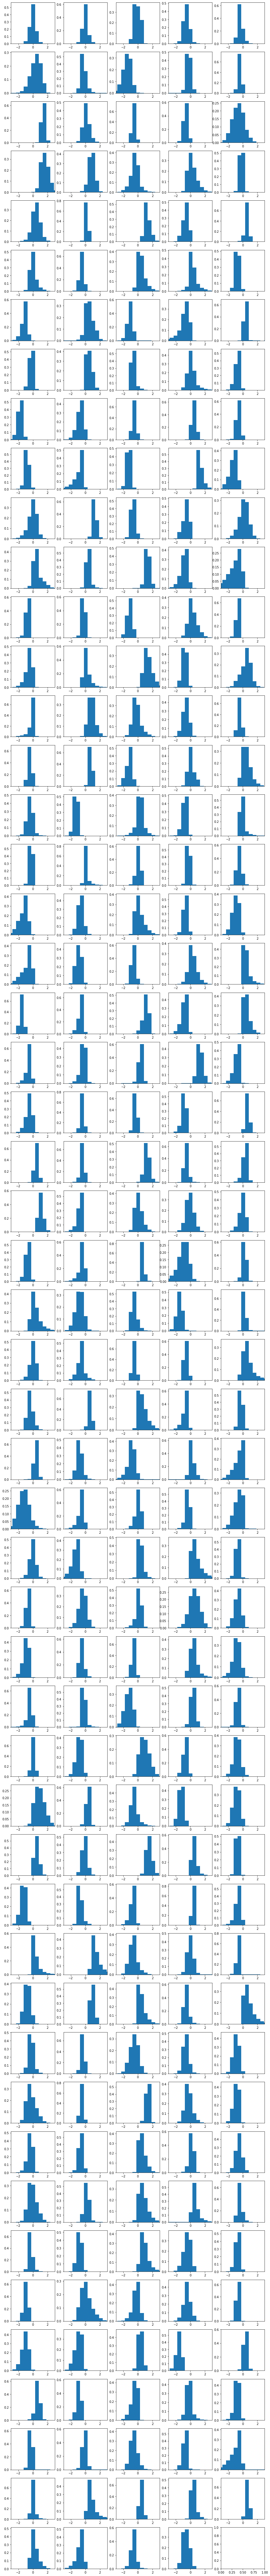

In [9]:
#Draw charts
data = np.reshape(voting_act_all, (-1))
bin_size = 0.52; min_edge = min(data); max_edge = max(data)
N = int((max_edge-min_edge)/bin_size); Nplus1 = N + 1
bin_list = np.linspace(min_edge, max_edge, Nplus1)

#plt.figure(figsize=(30,30))
fig, axs = plt.subplots(rows,  cols, figsize=(15,3*rows))
for i in range(rows):
    for j in range(cols):
        chn = i * 5 + j
        if chn >= num_channel: continue
        chn_data = voting_act_all[:,:,:,chn]
        chn_data = np.reshape(chn_data, (-1,))
        axs[i,j].hist(chn_data, bin_list, weights=np.ones(len(chn_data)) / len(chn_data))
        axs[i,j].set_xlim((-3,3))
        #axs[i,j].set_xlabel('Features part, mean: ' + '{0:.2f}'.format(np.mean(data)) + ', sd: ' + '{0:.2f}'.format(np.std(data)))
        #axs[i,j].set_ylabel('Count')

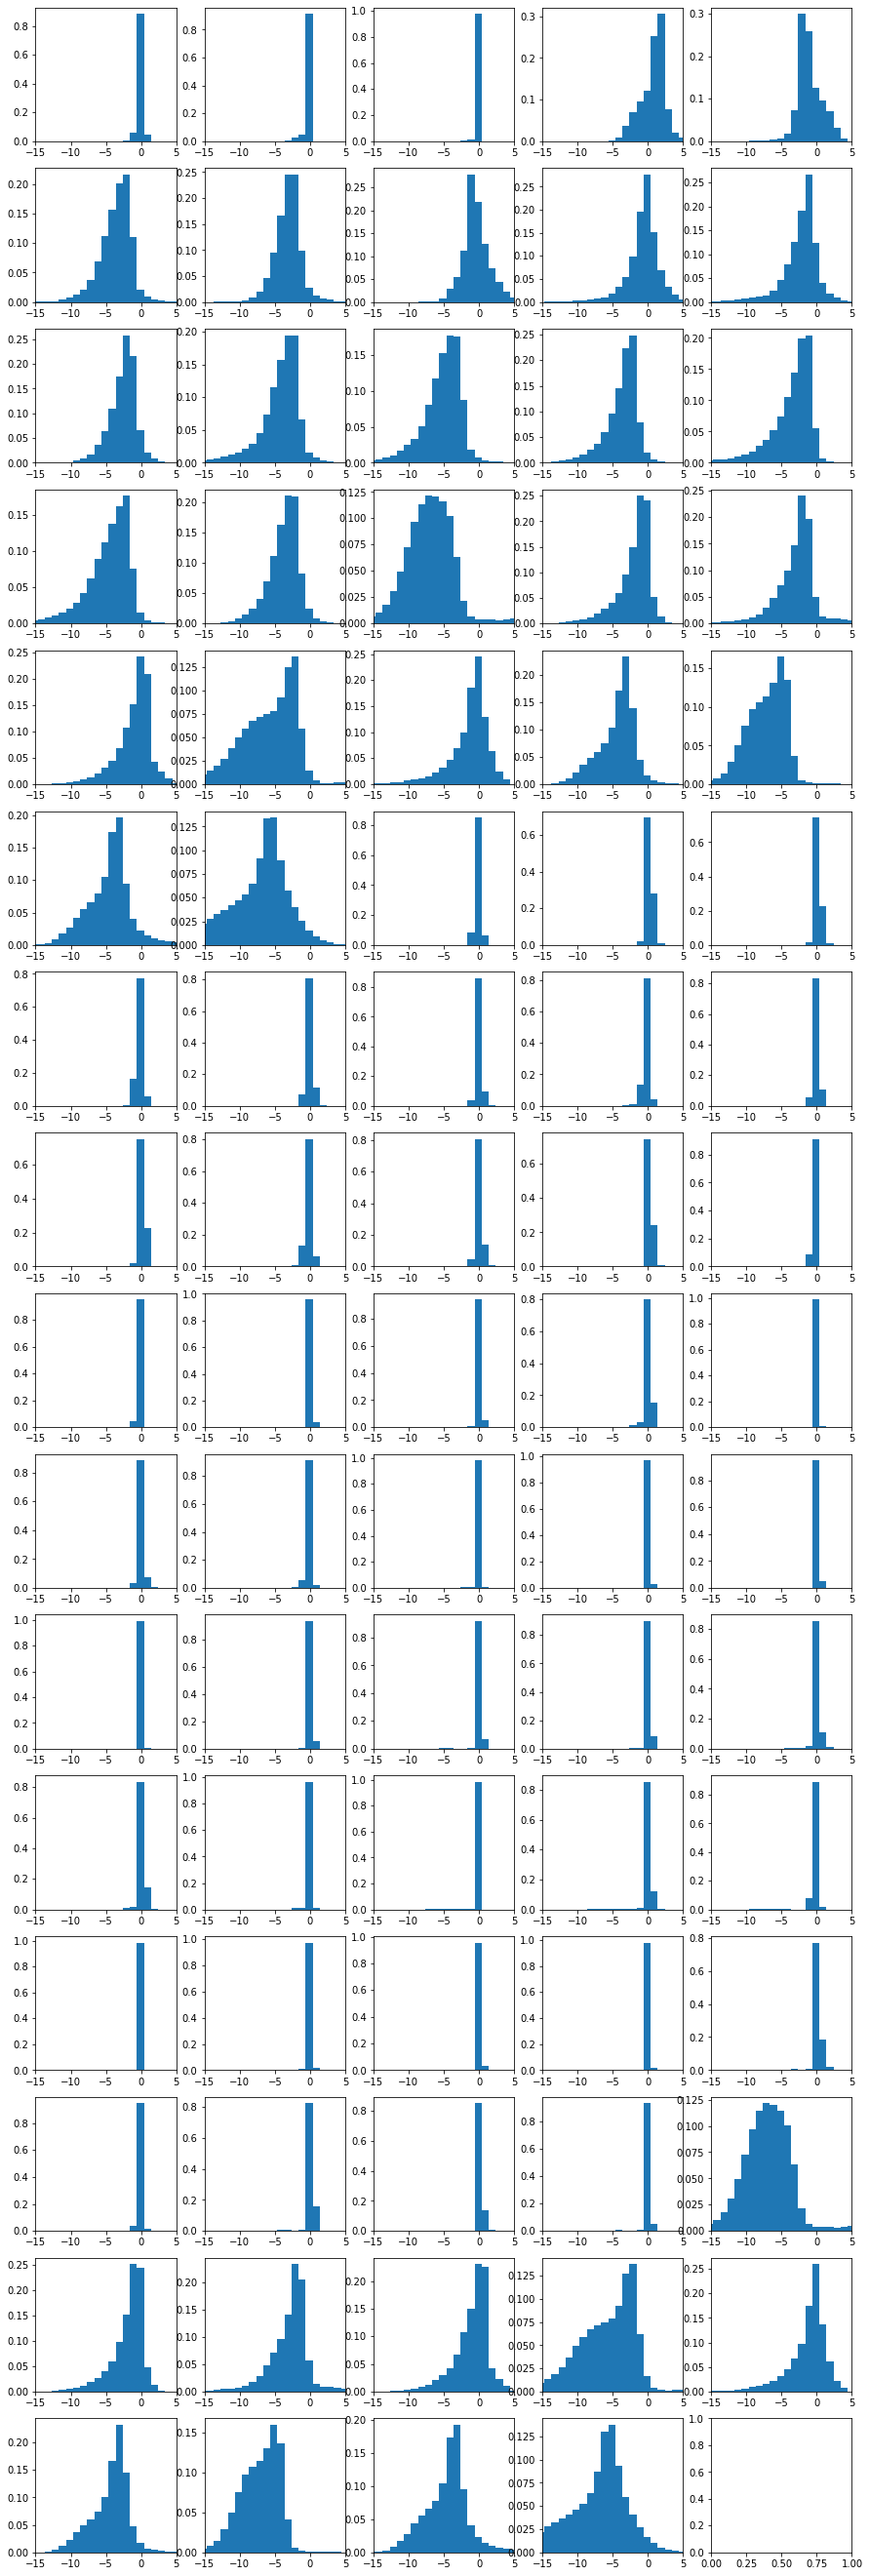

In [85]:
#Draw charts
data = np.reshape(proposal_act_all, (-1))
bin_size = 1; min_edge = min(data); max_edge = max(data)
N = int((max_edge-min_edge)/bin_size); Nplus1 = N + 1
bin_list = np.linspace(min_edge, max_edge, Nplus1)

#plt.figure(figsize=(30,30))
fig, axs = plt.subplots(rows,  cols, figsize=(15,3*rows))
for i in range(rows):
    for j in range(cols):
        chn = i * 5 + j
        if chn >= num_channel: continue
        chn_data = proposal_act_all[:,:,:,chn]
        chn_data = np.reshape(chn_data, (-1,))
        axs[i,j].hist(chn_data, bin_list, weights=np.ones(len(chn_data)) / len(chn_data))
        axs[i,j].set_xlim((-15,5))
        #axs[i,j].set_xlabel('Features part, mean: ' + '{0:.2f}'.format(np.mean(data)) + ', sd: ' + '{0:.2f}'.format(np.std(data)))
        #axs[i,j].set_ylabel('Count')


## Draw distribution charts

Text(0, 0.5, 'Count')

<Figure size 2160x2160 with 0 Axes>

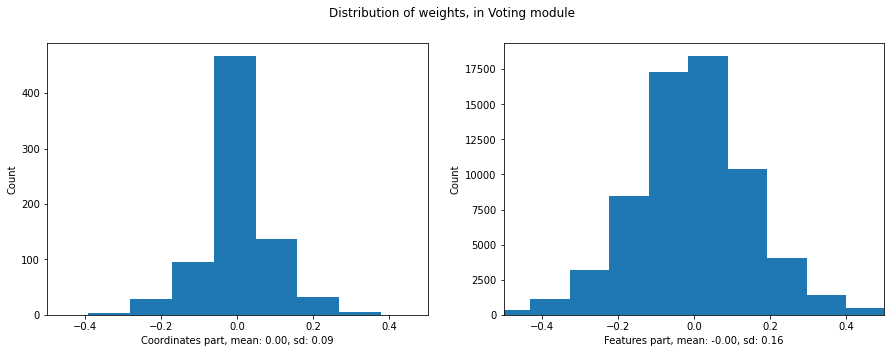

In [53]:
plt.figure(figsize=(30,30))
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))
fig.suptitle('Distribution of weights, in Voting module')

data = np.reshape(voting_w_coords, (-1))
bin_size = 0.1; min_edge = min(data); max_edge = max(data)
N = int((max_edge-min_edge)/bin_size); Nplus1 = N + 1
bin_list = np.linspace(min_edge, max_edge, Nplus1)
ax1.hist(data, bin_list)
ax1.set_xlim((-0.5,0.5))
ax1.set_xlabel('Coordinates part, mean: ' + '{0:.2f}'.format(np.mean(data)) + ', sd: ' + '{0:.2f}'.format(np.std(data)))
ax1.set_ylabel('Count')

data = np.reshape(voting_w_features, (-1))
bin_size = 0.1; min_edge = min(data); max_edge = max(data)
N = int((max_edge-min_edge)/bin_size); Nplus1 = N + 1
bin_list = np.linspace(min_edge, max_edge, Nplus1)

ax2.hist(data, bin_list)
ax2.set_xlim((-0.5,0.5))
ax2.set_xlabel('Features part, mean: ' + '{0:.2f}'.format(np.mean(data)) + ', sd: ' + '{0:.2f}'.format(np.std(data)))
ax2.set_ylabel('Count')

Text(0, 0.5, 'Count')

<Figure size 2160x2160 with 0 Axes>

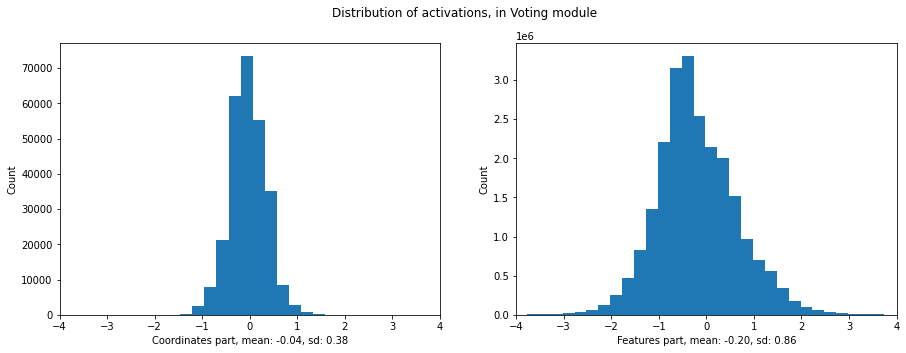

In [49]:
plt.figure(figsize=(30,30))
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))
fig.suptitle('Distribution of activations, in Voting module')

data = np.reshape(voting_act_coords, (-1))
bin_size = 0.25; min_edge = min(data); max_edge = max(data)
N = int((max_edge-min_edge)/bin_size); Nplus1 = N + 1
bin_list = np.linspace(min_edge, max_edge, Nplus1)
ax1.hist(data, bin_list)
ax1.set_xlim((-4,4))
ax1.set_xlabel('Coordinates part, mean: ' + '{0:.2f}'.format(np.mean(data)) + ', sd: ' + '{0:.2f}'.format(np.std(data)))
ax1.set_ylabel('Count')

data = np.reshape(voting_act_features, (-1))
bin_size = 0.25; min_edge = min(data); max_edge = max(data)
N = int((max_edge-min_edge)/bin_size); Nplus1 = N + 1
bin_list = np.linspace(min_edge, max_edge, Nplus1)

ax2.hist(data, bin_list)
ax2.set_xlim((-4,4))
ax2.set_xlabel('Features part, mean: ' + '{0:.2f}'.format(np.mean(data)) + ', sd: ' + '{0:.2f}'.format(np.std(data)))
ax2.set_ylabel('Count')

Text(0, 0.5, 'Count')

<Figure size 2160x2160 with 0 Axes>

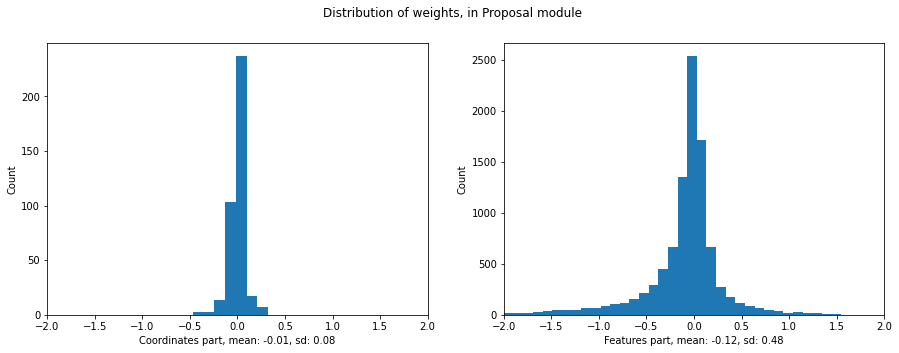

In [50]:
plt.figure(figsize=(30,30))
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))
fig.suptitle('Distribution of weights, in Proposal module')

data = np.reshape(proposal_w_coords, (-1))
bin_size = 0.1; min_edge = min(data); max_edge = max(data)
N = int((max_edge-min_edge)/bin_size); Nplus1 = N + 1
bin_list = np.linspace(min_edge, max_edge, Nplus1)
ax1.hist(data, bin_list)
ax1.set_xlim((-2,2))
ax1.set_xlabel('Coordinates part, mean: ' + '{0:.2f}'.format(np.mean(data)) + ', sd: ' + '{0:.2f}'.format(np.std(data)))
ax1.set_ylabel('Count')

data = np.reshape(proposal_w_features, (-1))
bin_size = 0.1; min_edge = min(data); max_edge = max(data)
N = int((max_edge-min_edge)/bin_size); Nplus1 = N + 1
bin_list = np.linspace(min_edge, max_edge, Nplus1)

ax2.hist(data, bin_list)
ax2.set_xlim((-2,2))
ax2.set_xlabel('Features part, mean: ' + '{0:.2f}'.format(np.mean(data)) + ', sd: ' + '{0:.2f}'.format(np.std(data)))
ax2.set_ylabel('Count')

Text(0, 0.5, 'Count')

<Figure size 2160x2160 with 0 Axes>

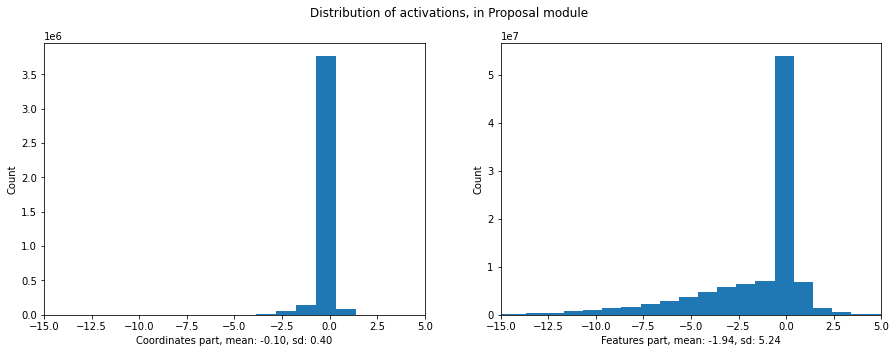

In [76]:
plt.figure(figsize=(30,30))
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))
fig.suptitle('Distribution of activations, in Proposal module')

data = np.reshape(proposal_act_coords, (-1))
bin_size = 1; min_edge = min(data); max_edge = max(data)
N = int((max_edge-min_edge)/bin_size); Nplus1 = N + 1
bin_list = np.linspace(min_edge, max_edge, Nplus1)
ax1.hist(data, bin_list)
ax1.set_xlim((-15,5))
ax1.set_xlabel('Coordinates part, mean: ' + '{0:.2f}'.format(np.mean(data)) + ', sd: ' + '{0:.2f}'.format(np.std(data)))
ax1.set_ylabel('Count')

data = np.reshape(proposal_act_features, (-1))
bin_size = 1; min_edge = min(data); max_edge = max(data)
N = int((max_edge-min_edge)/bin_size); Nplus1 = N + 1
bin_list = np.linspace(min_edge, max_edge, Nplus1)

ax2.hist(data, bin_list)
ax2.set_xlim((-15,5))
ax2.set_xlabel('Features part, mean: ' + '{0:.2f}'.format(np.mean(data)) + ', sd: ' + '{0:.2f}'.format(np.std(data)))
ax2.set_ylabel('Count')

In [75]:
!pip install plotinpy


  Created wheel for plotinpy: filename=plotinpy-0.1.1-py3-none-any.whl size=5238 sha256=31e28a09e40928ee9fb5f2d42f1a78882c6d77740f12e0d89946ed583702184e
  Stored in directory: /home/keondopark/.cache/pip/wheels/26/1e/84/d679be3e967542d1d9e8901d9917de9bce19e645252a15508e
Successfully built plotinpy


In [77]:
import plotinpy as pnp

{'figure': <Figure size 432x288 with 2 Axes>,
 'axes': [<AxesSubplot:>, <AxesSubplot:>]}

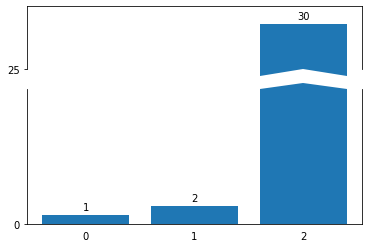

In [78]:
plt.figure()
pnp.plot_bars_with_breaks(
    [1, 2, 30],
    [(15, 25)]
    )

In [81]:
!pip install pandas

     |████████████████████████████████| 11.5 MB 7.3 MB/s eta 0:00:01
  Using cached pytz-2021.3-py2.py3-none-any.whl (503 kB)


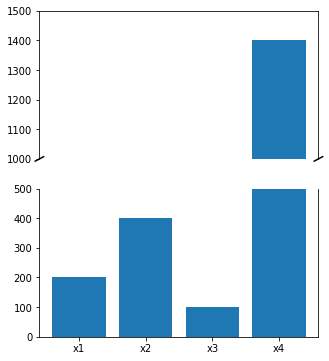

In [104]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

XX = pd.Series([200,400,100,1400],index=['x1','x2','x3','x4'])
fig, (ax1,ax2) = plt.subplots(2,1,sharex=True,
                         figsize=(5,6))
ax1.spines['bottom'].set_visible(False)
ax1.tick_params(axis='x',which='both',bottom=False)
ax2.spines['top'].set_visible(False)

bs = 500
ts = 1000

ax2.set_ylim(0,bs)
ax1.set_ylim(ts,1500)
ax1.set_yticks(np.arange(1000,1501,100))

bars1 = ax1.bar(XX.index, XX.values)
bars2 = ax2.bar(XX.index, XX.values)

for tick in ax2.get_xticklabels():
    tick.set_rotation(0)
d = .015  

kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((-d, +d), (-d, +d), **kwargs)      
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)

kwargs.update(transform=ax2.transAxes)  
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)


for b1, b2 in zip(bars1, bars2):
    posx = b2.get_x() + b2.get_width()/2.
    if b2.get_height() > bs:
        ax2.plot((posx-3*d, posx+3*d), (1 - d, 1 + d), color='k', clip_on=False,
                 transform=ax2.get_xaxis_transform())
    if b1.get_height() > ts:
        ax1.plot((posx-3*d, posx+3*d), (- d, + d), color='k', clip_on=False,
                 transform=ax1.get_xaxis_transform())

plt.show()

In [36]:
plt.rcParams["font.family"] = 'Times New Roman'

### Latency chart for SUN RGB-D

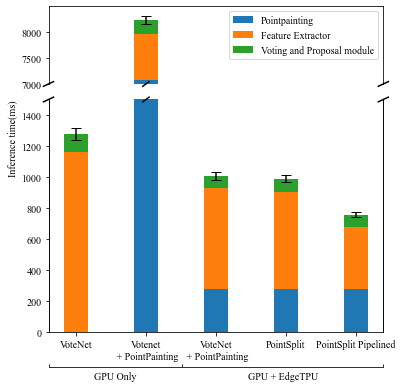

In [99]:
labels = ['VoteNet', 'Votenet\n + PointPainting', 'VoteNet\n + PointPainting', 'PointSplit', 'PointSplit Pipelined']
pointpainting = [0, 7072, 283, 280, 282]
FeatureExtractor = [1164, 901, 650, 625, 395]
VotingProposal_bottom = [1164,7974,933,905,677]
VotingProposal = [112,268,72,85,82]

error = [39, 76, 25, 23, 14]
#women_std = [3, 5, 2, 3, 3]
width = 0.35       # the width of the bars: can also be len(x) sequence

#plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)

fig, (ax1,ax2) = plt.subplots(2,1,sharex=True,figsize=(6,6), gridspec_kw={'height_ratios': [1, 3]})
plt.subplots_adjust(hspace=0.1)
bs = 1500
ts = 7000

# Draw axis on both ax1, ax2
ax2.set_ylim(0,bs)
ax1.set_ylim(ts,8500)
ax1.set_yticks(np.arange(ts,8500,500))
ax1.spines['bottom'].set_visible(False)
ax1.tick_params(axis='x',which='both',bottom=False)
ax2.spines['top'].set_visible(False)

# Draw stacked bars on both ax1, ax2
#bars2 = ax2.bar(labels, pointpainting, width, yerr=men_std, label='pointpainting')
bars2 = ax2.bar(labels, pointpainting, width, label='Pointpainting')
ax2.bar(labels, FeatureExtractor, width, bottom=pointpainting,
       label='Feature Extractor')
ax2.bar(labels, VotingProposal, width, bottom=VotingProposal_bottom,
       label='Voting and Proposal',
       yerr=error, capsize=5)
bars1 = ax1.bar(labels, pointpainting, width, label='Pointpainting')
ax1.bar(labels, FeatureExtractor, width, bottom=pointpainting,
       label='Feature Extractor')
ax1.bar(labels, VotingProposal, width, bottom=VotingProposal_bottom,
       label='Voting and Proposal module',
       yerr=error, capsize=5)

# Break mark on axis
d = .015  
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((-d, +d), (-2*d, +2*d), **kwargs)      
ax1.plot((1 - d, 1 + d), (-2*d, +2*d), **kwargs)

kwargs.update(transform=ax2.transAxes)  
ax2.plot((-d, +d), (1 - 2/3*d, 1 + 2/3*d), **kwargs)  
ax2.plot((1 - d, 1 + d), (1 - 2/3*d, 1 + 2/3*d), **kwargs)

for b1, b2 in zip(bars1, bars2):
    posx = b2.get_x() + b2.get_width()/2.
    if b2.get_height() > bs:
        ax2.plot((posx-3*d, posx+3*d), (1 - 2/3*d, 1 + 2/3*d), color='k', clip_on=False,
                 transform=ax2.get_xaxis_transform())
    if b1.get_height() > ts:
        ax1.plot((posx-3*d, posx+3*d), (- 2*d, + 2*d), color='k', clip_on=False,
                 transform=ax1.get_xaxis_transform())


ax2.set_ylabel('Inference time(ms)',loc="top", **{'fontname':'Times New Roman'})
#ax1.set_title('Inference time comparison', **{'fontname':'Times New Roman'})
ax1.legend()

# Second X-axis
import matplotlib.ticker as ticker
ax3 = ax2.twiny()

ax3.spines["bottom"].set_position(("axes", -0.15))
ax3.spines['top'].set_visible(False)
ax3.tick_params('both', length=0, width=0, which='minor')
ax3.tick_params('both', direction='in', which='major')
ax3.xaxis.set_ticks_position("bottom")
ax3.xaxis.set_label_position("bottom")

ax3.set_xticks([0.0, 0.4, 1.0])
ax3.xaxis.set_major_formatter(ticker.NullFormatter())
ax3.xaxis.set_minor_locator(ticker.FixedLocator([0.2, 0.7]))
ax3.xaxis.set_minor_formatter(ticker.FixedFormatter(['GPU Only', 'GPU + EdgeTPU']))

plt.savefig('figs/latency_plot_sunrgbd.pdf')
plt.show()

### Latency chart for Scannet

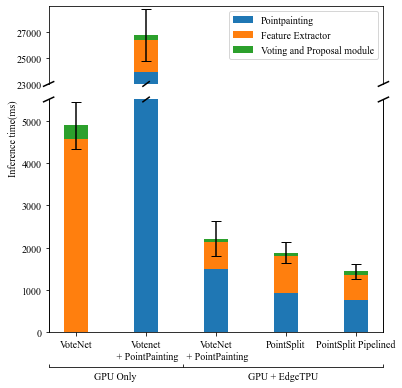

In [100]:
labels = ['VoteNet', 'Votenet\n + PointPainting', 'VoteNet\n + PointPainting', 'PointSplit', 'PointSplit Pipelined']
pointpainting = [0, 23908, 1488, 939, 763]
FeatureExtractor = [4565, 2450, 645, 855, 599]
VotingProposal_bottom = [4565,26358,2133,1795,1362]
VotingProposal = [324,389,80,92,82]
error = [548, 2008, 417, 253, 177]
#women_std = [3, 5, 2, 3, 3]
width = 0.35       # the width of the bars: can also be len(x) sequence

#plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)

fig, (ax1,ax2) = plt.subplots(2,1,sharex=True,figsize=(6,6), gridspec_kw={'height_ratios': [1, 3]})
plt.subplots_adjust(hspace=0.1)
bs = 5500
ts = 23000

# Draw axis on both ax1, ax2
ax2.set_ylim(0,bs)
ax1.set_ylim(ts,29000)
ax1.set_yticks(np.arange(ts,29000,2000))
ax1.spines['bottom'].set_visible(False)
ax1.tick_params(axis='x',which='both',bottom=False)
ax2.spines['top'].set_visible(False)

# Draw stacked bars on both ax1, ax2
#bars2 = ax2.bar(labels, pointpainting, width, yerr=men_std, label='pointpainting')
bars2 = ax2.bar(labels, pointpainting, width, label='Pointpainting')
ax2.bar(labels, FeatureExtractor, width, bottom=pointpainting,
       label='Feature Extractor')
ax2.bar(labels, VotingProposal, width, bottom=VotingProposal_bottom,
       label='Voting and Proposal',
       yerr=error, capsize=5)
bars1 = ax1.bar(labels, pointpainting, width, label='Pointpainting')
ax1.bar(labels, FeatureExtractor, width, bottom=pointpainting,
       label='Feature Extractor')
ax1.bar(labels, VotingProposal, width, bottom=VotingProposal_bottom,
       label='Voting and Proposal module',
       yerr=error, capsize=5)

# Break mark on axis
d = .015  
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((-d, +d), (-2*d, +2*d), **kwargs)      
ax1.plot((1 - d, 1 + d), (-2*d, +2*d), **kwargs)

kwargs.update(transform=ax2.transAxes)  
ax2.plot((-d, +d), (1 - 2/3*d, 1 + 2/3*d), **kwargs)  
ax2.plot((1 - d, 1 + d), (1 - 2/3*d, 1 + 2/3*d), **kwargs)

for b1, b2 in zip(bars1, bars2):
    posx = b2.get_x() + b2.get_width()/2.
    if b2.get_height() > bs:
        ax2.plot((posx-3*d, posx+3*d), (1 - 2/3*d, 1 + 2/3*d), color='k', clip_on=False,
                 transform=ax2.get_xaxis_transform())
    if b1.get_height() > ts:
        ax1.plot((posx-3*d, posx+3*d), (- 2*d, + 2*d), color='k', clip_on=False,
                 transform=ax1.get_xaxis_transform())


ax2.set_ylabel('Inference time(ms)',loc="top", **{'fontname':'Times New Roman'})
#ax1.set_title('Inference time comparison', **{'fontname':'Times New Roman'})
ax1.legend()

# Second X-axis
import matplotlib.ticker as ticker
ax3 = ax2.twiny()

ax3.spines["bottom"].set_position(("axes", -0.15))
ax3.spines['top'].set_visible(False)
ax3.tick_params('both', length=0, width=0, which='minor')
ax3.tick_params('both', direction='in', which='major')
ax3.xaxis.set_ticks_position("bottom")
ax3.xaxis.set_label_position("bottom")

ax3.set_xticks([0.0, 0.4, 1.0])
ax3.xaxis.set_major_formatter(ticker.NullFormatter())
ax3.xaxis.set_minor_locator(ticker.FixedLocator([0.2, 0.7]))
ax3.xaxis.set_minor_formatter(ticker.FixedFormatter(['GPU Only', 'GPU + EdgeTPU'], ))

plt.savefig('figs/latency_plot_scannet.pdf')
plt.show()